In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from config import RESULTS, FIGURES
from code_.tools.plotting import *
from code_.model_activations.configs import analysis_cfg

In [2]:
MULTIPLIER = 36

def load_and_prepare_data(model_name, multiplier, dataset, region):    
    filepath = os.path.join(RESULTS, f'bootstrap-results-{model_name}-{dataset}-{region}.csv')
    df = pd.read_csv(filepath)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
    return df

In [3]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = analysis_cfg[DATASET]['regions']

In [4]:
# loading linear model data
df_random = load_and_prepare_data('fully_random', MULTIPLIER, DATASET, region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, DATASET, region)
#join dataframes
df = pd.concat([df_random,df_expansion]).reset_index(drop=True)
# alexnet data
df_alexnet = pd.read_csv(os.path.join(RESULTS, f'bootstrap-results-alexnet_trained-{DATASET}-{region}.csv'))
df_alexnet['score'] = df_alexnet['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))


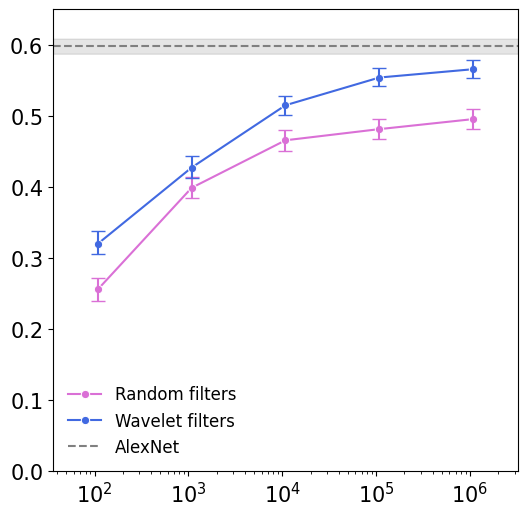

In [5]:
names ={'expansion':'Wavelet filters','fully_random':'Random filters'}
palette ={'Wavelet filters':'royalblue', 'Random filters':'orchid'}
df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])


# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='gray', alpha=0.2)


plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
plt.xlabel('')
plt.ylabel('')    
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.savefig(os.path.join(FIGURES,f'figure_S7_{DATASET}_{region}.png'), dpi=200) 
plt.show()